In [112]:
from PIL import Image
from enum import Enum

In [113]:
class CardinalDirection(Enum):
    UP = 0
    LEFT = 1
    DOWN = 2
    RIGHT = 3


class GridObject:
    def __init__(self, position: tuple[int, int]):
        self.position = position

    def __repr__(self):
        return f'{self.__class__.__name__}({self.position})'


class EmptySquare(GridObject):
    def __init__(self, position: tuple[int, int]):
        super().__init__(position)


class Obstacle(GridObject):
    def __init__(self, position: tuple[int, int]):
        super().__init__(position)


class Box(Obstacle):
    def __init__(self, x, y):
        super().__init__((x, y))


class Wall(Obstacle):
    def __init__(self, x, y):
        super().__init__((x, y))


class Robot(GridObject):
    def __init__(self, x: int, y: int, commands: list[CardinalDirection]):
        super().__init__((x, y))
        self.commands = commands

    def __repr__(self):
        return f'Robot(p={self.position})'


class Grid:
    MOVEMENT = {
        CardinalDirection.UP: lambda i, j: (i - 1, j),
        CardinalDirection.DOWN: lambda i, j: (i + 1, j),
        CardinalDirection.LEFT: lambda i, j: (i, j - 1),
        CardinalDirection.RIGHT: lambda i, j: (i, j + 1),
    }

    def __init__(self, data: list[list[GridObject]], robot: Robot):
        self.width = len(data[0])
        self.height = len(data)
        self.data = data
        self.robot = robot
        self.debug = False

    def move_object(self, direction: CardinalDirection, from_position: tuple[int, int]) -> int:
        """Return the amount of objects moved"""
        try:
            grid_object = self.data[from_position[0]][from_position[1]]
            next_position = Grid.MOVEMENT[direction](*from_position)
            next_object = self.data[next_position[0]][next_position[1]]
        except IndexError:
            return 0

        if isinstance(next_object, EmptySquare):
            self.data[from_position[0]][from_position[1]] = next_object
            self.data[next_position[0]][next_position[1]] = grid_object
            grid_object.position = next_position
            next_object.position = from_position
            return 1
        elif isinstance(next_object, Box):
            objects_moved = self.move_object(direction, next_position)
            if objects_moved > 0:
                objects_moved += self.move_object(direction, from_position)
            return objects_moved
        elif isinstance(next_object, Wall):
            return 0
        else:
            raise ValueError(f'Unexpected object type: {type(next_object)}')

    def run_robot(self):
        i = 0
        if self.debug:
            img = self.visualize(12)
            img.save(f"../../data/day15/{i:06}.png")
        for i, direction in enumerate(self.robot.commands):
            self.move_object(direction, self.robot.position)
            if self.debug:
                img = self.visualize(12)
                img.save(f"../../data/day15/{(i + 1):06}.png")

    def visualize(self, scale=10):
        img = Image.new('RGB', (scale * self.width, scale * self.height), 'black')
        pixels = img.load()

        for i, row in enumerate(self.data):
            for j, grid_object in enumerate(row):
                color = (125, 125, 125)
                if isinstance(grid_object, EmptySquare):
                    color = (255, 255, 255)
                elif isinstance(grid_object, Box):
                    color = (0, 255, 0)
                elif isinstance(grid_object, Robot):
                    color = (255, 0, 0)
                elif isinstance(grid_object, Wall):
                    color = (0, 0, 255)
                for px_i in range(scale):
                    for px_j in range(scale):
                        pixels[scale * j + px_j, scale * i + px_i] = color
        return img


def load_input():
    robot = None
    commands = []
    with open("../../data/day15-input.txt") as f:
        sections = f.read().split('\n\n')
        assert 2 == len(sections)

        for instruction in sections[1].strip().replace('\n', ''):
            if instruction == '^':
                commands.append(CardinalDirection.UP)
            elif instruction == '<':
                commands.append(CardinalDirection.LEFT)
            elif instruction == 'v':
                commands.append(CardinalDirection.DOWN)
            elif instruction == '>':
                commands.append(CardinalDirection.RIGHT)
            else:
                raise ValueError("Unrecognized instruction: " + instruction)

        data = []
        for i, line in enumerate(sections[0].split('\n')):
            row = []
            for j, c in enumerate(line):
                if c == '#':
                    row.append(Wall(i, j))
                elif c == 'O':
                    row.append(Box(i, j))
                elif c == '@':
                    if robot is not None:
                        raise ValueError('Robot already loaded')
                    robot = Robot(i, j, commands)
                    row.append(robot)
                elif c == '.':
                    row.append(EmptySquare((i, j)))
                else:
                    raise ValueError("Unhandled: " + c)
            data.append(row)
        grid = Grid(data, robot)

        return grid


grid = load_input()
grid.debug = False
grid.run_robot()

In [114]:
grid.visualize().save("../../data/day15/output.png")

In [115]:
box_sum = 0
for i, row in enumerate(grid.data):
    for j, grid_object in enumerate(row):
        if isinstance(grid_object, Box):
            box_sum += 100 * i + j
print(box_sum)
del i, j, row, box_sum, grid_object

1479679


### Part 2
Now the boxes and walls double in width. The boxes have a left and right half and need to remain connected as they are moved.
It would seem that the only time you have to worry about moving the wide boxes differently are when you move them in the up or down directions. Otherwise, the same old rules for left and right movement apply.
For vertical movement, then you need to run the same movement logic on the box's counterpart.

In [116]:
class WideBox(Box):
    def __init__(self, x, y, other_side: 'WideBox' = None):
        super().__init__(x, y)
        self.other_side: 'WideBox' = other_side


class LeftBox(WideBox):
    def __init__(self, x, y, other_side: 'RightBox' = None):
        super().__init__(x, y, other_side)


class RightBox(WideBox):
    def __init__(self, x, y, other_side: 'LeftBox' = None):
        super().__init__(x, y, other_side)


class WideGrid:
    def __init__(self, data, robot):
        self.width = len(data[0])
        self.height = len(data)
        self.data = data
        self.robot = robot
        self.debug = False

    def run_robot(self):
        i = 0
        if self.debug:
            img = self.visualize(12)
            img.save(f"../../data/day15/{i:06}.png")
        for i, direction in enumerate(self.robot.commands):
            self.move_object(direction, self.robot.position)
            if self.debug:
                img = self.visualize(12)
                img.save(f"../../data/day15/{(i + 1):06}.png")

    def check_if_box_can_move_vertically(self, direction: CardinalDirection, wide_box: WideBox):
        """
        Goal is to keep track of additionl boxes and ensure that the final set can be pushed
        into a free square.
        """
        if direction != CardinalDirection.UP and direction != CardinalDirection.DOWN:
            raise ValueError("Unexpected direction: {}".format(direction))

        try:
            from_position_a = wide_box.position
            from_position_b = wide_box.other_side.position
            next_position_a = Grid.MOVEMENT[direction](*from_position_a)
            next_position_b = Grid.MOVEMENT[direction](*from_position_b)
            next_object_a = self.data[next_position_a[0]][next_position_a[1]]
            next_object_b = self.data[next_position_b[0]][next_position_b[1]]
        except IndexError:
            return False

        if isinstance(next_object_a, EmptySquare) and isinstance(next_object_b, EmptySquare):
            return True

        if isinstance(next_object_a, Wall) or isinstance(next_object_b, Wall):
            return False

        if isinstance(next_object_a, WideBox):
            if not self.check_if_box_can_move_vertically(direction, next_object_a):
                return False

        if isinstance(next_object_b, WideBox):
            if not self.check_if_box_can_move_vertically(direction, next_object_b):
                return False

        return True

    def move_wide_box_vertically(self, direction: CardinalDirection, wide_box: WideBox) -> int:
        """ Expect UP or DOWN and return number of objects actually moved """
        if direction != CardinalDirection.UP and direction != CardinalDirection.DOWN:
            raise ValueError("Unexpected direction: {}".format(direction))

        try:
            from_position_a = wide_box.position
            from_position_b = wide_box.other_side.position
            next_position_a = Grid.MOVEMENT[direction](*from_position_a)
            next_position_b = Grid.MOVEMENT[direction](*from_position_b)
            next_object_a = self.data[next_position_a[0]][next_position_a[1]]
            next_object_b = self.data[next_position_b[0]][next_position_b[1]]
        except IndexError:
            return 0

        if not self.check_if_box_can_move_vertically(direction, wide_box):
            return 0

        if isinstance(next_object_a, Wall) or isinstance(next_object_b, Wall):
            return 0
        if isinstance(next_object_a, EmptySquare) and isinstance(next_object_b, EmptySquare):
            self.data[from_position_a[0]][from_position_a[1]] = next_object_a
            next_object_a.position = from_position_a

            self.data[from_position_b[0]][from_position_b[1]] = next_object_b
            next_object_b.position = from_position_b

            self.data[next_position_a[0]][next_position_a[1]] = wide_box
            wide_box.position = next_position_a

            self.data[next_position_b[0]][next_position_b[1]] = wide_box.other_side
            wide_box.other_side.position = next_position_b
            return 1
        if isinstance(next_object_a, WideBox) and isinstance(next_object_b, EmptySquare):
            objects_moved = self.move_wide_box_vertically(direction, next_object_a)
            if objects_moved > 0:
                objects_moved += self.move_wide_box_vertically(direction, wide_box)
            return objects_moved
        elif isinstance(next_object_a, EmptySquare) and isinstance(next_object_b, WideBox):
            objects_moved = self.move_wide_box_vertically(direction, next_object_b)
            if objects_moved > 0:
                objects_moved += self.move_wide_box_vertically(direction, wide_box.other_side)
            return objects_moved
        elif isinstance(next_object_a, WideBox) and isinstance(next_object_b, WideBox):
            if next_object_a is next_object_b.other_side:
                objects_moved = self.move_wide_box_vertically(direction, next_object_a)
                if objects_moved > 0:
                    objects_moved += self.move_wide_box_vertically(direction, wide_box)
                return objects_moved
            else:
                objects_moved = self.move_wide_box_vertically(direction, next_object_a)
                objects_moved += self.move_wide_box_vertically(direction, next_object_b)
                objects_moved += self.move_wide_box_vertically(direction, wide_box)
            return objects_moved
        raise ValueError(f'Unexpected object types: {type(next_object_a)}, {type(next_object_b)}')

    def move_object(self, direction: CardinalDirection, from_position: tuple[int, int]) -> int:
        try:
            grid_object = self.data[from_position[0]][from_position[1]]
            next_position = Grid.MOVEMENT[direction](*from_position)
            next_object = self.data[next_position[0]][next_position[1]]
        except IndexError:
            return 0

        if isinstance(next_object, EmptySquare):
            self.data[from_position[0]][from_position[1]] = next_object
            self.data[next_position[0]][next_position[1]] = grid_object
            grid_object.position = next_position
            next_object.position = from_position
            return 1
        elif isinstance(next_object, Box):
            if direction == CardinalDirection.UP or direction == CardinalDirection.DOWN:
                objects_moved = self.move_wide_box_vertically(direction, next_object)
                if objects_moved > 0:
                    objects_moved += self.move_object(direction, from_position)
                return objects_moved
            objects_moved = self.move_object(direction, next_position)
            if objects_moved > 0:
                objects_moved += self.move_object(direction, from_position)
            return objects_moved
        elif isinstance(next_object, Wall):
            return 0
        else:
            raise ValueError(f'Unexpected object type: {type(next_object)}')

    def visualize(self, scale=10):
        img = Image.new('RGB', (scale * self.width, scale * self.height), 'black')
        pixels = img.load()

        for i, row in enumerate(self.data):
            for j, grid_object in enumerate(row):
                color = (125, 125, 125)
                if isinstance(grid_object, EmptySquare):
                    color = (255, 255, 255)
                elif isinstance(grid_object, Box):
                    color = (0, 255, 0)
                elif isinstance(grid_object, Robot):
                    color = (255, 0, 0)
                elif isinstance(grid_object, Wall):
                    color = (0, 0, 255)
                for px_i in range(scale):
                    for px_j in range(scale):
                        pixels[scale * j + px_j, scale * i + px_i] = color
        return img


def load_input():
    robot = None
    commands = []
    with open("../../data/day15-input.txt") as f:
        #with open("../../data/day15-part2-sample.txt") as f:
        sections = f.read().split('\n\n')
        assert 2 == len(sections)

        for instruction in sections[1].strip().replace('\n', ''):
            if instruction == '^':
                commands.append(CardinalDirection.UP)
            elif instruction == '<':
                commands.append(CardinalDirection.LEFT)
            elif instruction == 'v':
                commands.append(CardinalDirection.DOWN)
            elif instruction == '>':
                commands.append(CardinalDirection.RIGHT)
            else:
                raise ValueError("Unrecognized instruction: " + instruction)

        data = []
        for i, line in enumerate(sections[0].split('\n')):
            row = []
            for j, c in enumerate(line):
                if c == '#':
                    row.append(Wall(i, 2 * j))
                    row.append(Wall(i, 2 * j + 1))
                elif c == 'O':
                    left_side = LeftBox(i, 2 * j)
                    right_side = RightBox(i, 2 * j + 1)
                    left_side.other_side = right_side
                    right_side.other_side = left_side
                    row.append(left_side)
                    row.append(right_side)
                elif c == '@':
                    if robot is not None:
                        raise ValueError('Robot already loaded')
                    robot = Robot(i, 2 * j, commands)
                    row.append(robot)
                    row.append(EmptySquare((i, 2 * j + 1)))
                elif c == '.':
                    row.append(EmptySquare((i, 2 * j)))
                    row.append(EmptySquare((i, 2 * j + 1)))
                else:
                    raise ValueError("Unhandled: " + c)
            data.append(row)
        grid = WideGrid(data, robot)

        return grid

#grid = load_input()
#grid.debug = True
#grid.run_robot()



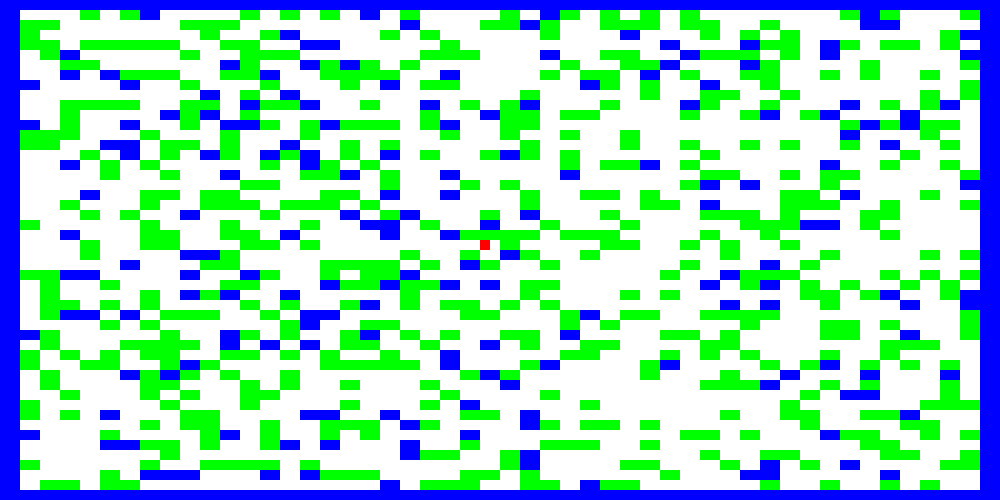

In [117]:
grid = load_input()
grid.visualize()

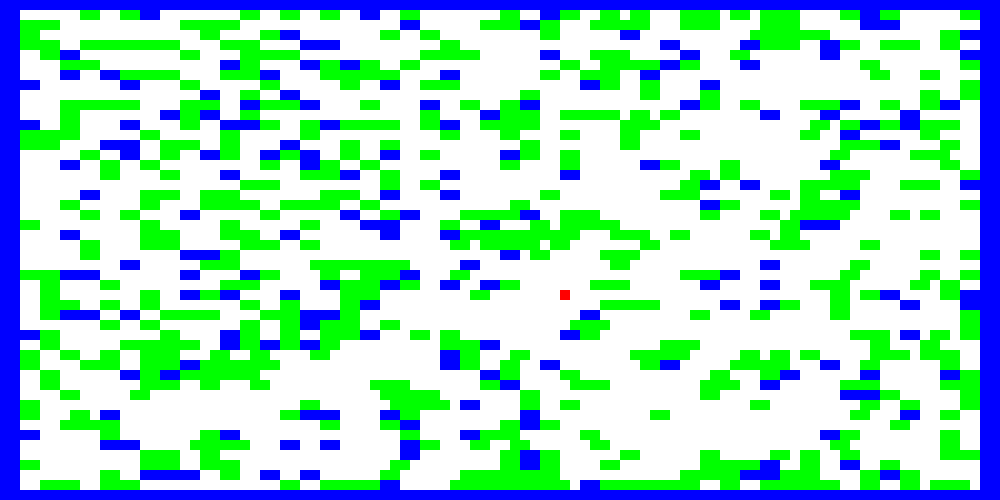

In [118]:
grid.run_robot()
grid.visualize()

In [119]:
box_sum = 0
for i, row in enumerate(grid.data):
    for j, grid_object in enumerate(row):
        if isinstance(grid_object, LeftBox):
            box_sum += 100 * i + j
print(box_sum)
del i, j, row, box_sum, grid_object

1509780
